In [1]:
import importlib
import os
from joblib import dump, load

import numpy as np
import pandas as pd

import tensorflow as tf

from sklearn.preprocessing import MultiLabelBinarizer

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

from nltk import download as nltk_download
from nltk import tokenize, RegexpTokenizer
from nltk.corpus import stopwords
nltk_download('punkt')
nltk_download('stopwords')
from nltk.stem.snowball import SnowballStemmer


data_path = "..\\data\\stackoverflow\\"
model_path = data_path + "models\\"

np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = "{:,.2f}".format

# https://github.com/tensorflow/text/issues/476

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vince\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vince\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [3]:
# data_filename = "bs4_nltk.pkl"
data_filename = "bs4.pkl"
df_base = pd.read_pickle(data_path + data_filename)
df_top = pd.read_pickle(data_path + 'Top_Tags.pkl')
# body_corpus = load(data_path + 'body_corpus.joblib')

In [4]:
df = pd.read_pickle(data_path + 'nltk_lemma_stop.pkl')

mlb = MultiLabelBinarizer()
df_tags = pd.read_pickle(data_path + 'Top_Tags.pkl')
df_tags_test = pd.read_pickle(data_path + 'Top_Tags_test.pkl')
df_tags_full = pd.concat([df_tags,df_tags_test])
mlb.fit_transform(df_tags_full['Tags_T50'])

y_tags = mlb.transform(df_tags['Tags_T50'])
y_tags_test = mlb.transform(df_tags_test['Tags_T50'])

y_tag_python = y_tags[:,np.where(mlb.classes_=="python")]

In [5]:
df['Body'] = df['Body'].apply(lambda row: ' '.join(row))

In [6]:
# body_vectorizer = load(model_path + 'body_vectorizer_13.joblib')
body_vectorizer = load(model_path + 'lemma_body_vectorizer_13.joblib')
X_body = body_vectorizer.transform(df['Body'])

In [38]:
COUNT = 100000
SPLIT_RATIO = .8
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 128

tfidf_dataset =  tf.data.Dataset.from_tensor_slices((X_body[:COUNT].toarray(), y_tags[:COUNT]))
tfidf_train_dataset, tfidf_test_dataset = tfidf_dataset.take(tfidf_dataset.cardinality().numpy()*SPLIT_RATIO), tfidf_dataset.skip(tfidf_dataset.cardinality().numpy()*SPLIT_RATIO)
tfidf_train_data = tfidf_train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
tfidf_test_data = tfidf_test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [43]:

EMBEDING_DIM = 44
DROPOUT = .37
LABEL_SMOOTHING = 0

model = tf.keras.Sequential([
    tf.keras.layers.Dense(EMBEDING_DIM,
            input_shape=(4000,),
            activation='relu',
                ),
    tf.keras.layers.Dropout(DROPOUT),
    tf.keras.layers.Dense(EMBEDING_DIM, activation='relu', 
                ),
    tf.keras.layers.Dropout(DROPOUT),
    tf.keras.layers.Dense(51, activation='sigmoid'),
])



metrics = [
    tf.keras.metrics.PrecisionAtRecall(0.4),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.FalsePositives(name='fp'),
#     keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
#     keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING),
    metrics=metrics,
)

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 44)                176044    
_________________________________________________________________
dropout_20 (Dropout)         (None, 44)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 44)                1980      
_________________________________________________________________
dropout_21 (Dropout)         (None, 44)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 51)                2295      
Total params: 180,319
Trainable params: 180,319
Non-trainable params: 0
_________________________________________________________________


In [44]:
history = model.fit(
    tfidf_train_data,
    epochs=20,
    validation_data=tfidf_test_data,
)

Epoch 1/20
1206/1206 [==============================] - 33s 26ms/step - loss: 0.2208 - precision_at_recall_10: 0.0582 - recall: 0.0345 - auc: 0.6413 - fp: 24564.9337 - fn: 55865.9909 - tp: 1419.3712 - accuracy: 0.9419 - precision: 0.0518 - val_loss: 0.0957 - val_precision_at_recall_10: 0.2883 - val_recall: 0.0693 - val_auc: 0.8818 - val_fp: 960.0000 - val_fn: 26600.0000 - val_tp: 1981.0000 - val_accuracy: 0.9720 - val_precision: 0.6736
Epoch 2/20
1206/1206 [==============================] - 30s 25ms/step - loss: 0.0984 - precision_at_recall_10: 0.2658 - recall: 0.0794 - auc: 0.8647 - fp: 2904.0348 - fn: 52425.2378 - tp: 4859.5601 - accuracy: 0.9719 - precision: 0.6122 - val_loss: 0.0811 - val_precision_at_recall_10: 0.4649 - val_recall: 0.1389 - val_auc: 0.9286 - val_fp: 1488.0000 - val_fn: 24612.0000 - val_tp: 3969.0000 - val_accuracy: 0.9735 - val_precision: 0.7273
Epoch 3/20
1206/1206 [==============================] - 30s 25ms/step - loss: 0.0864 - precision_at_recall_10: 0.4017 - 

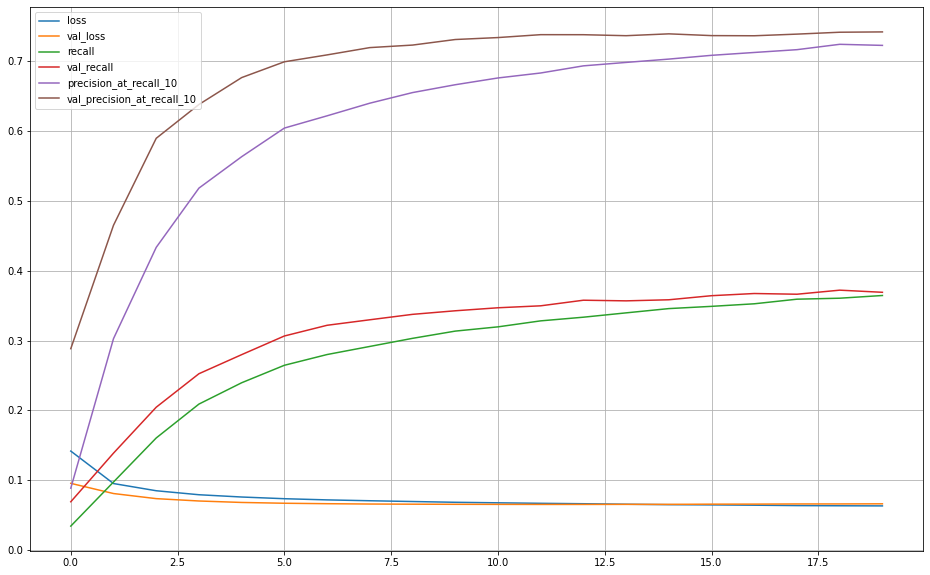

In [47]:
cols_1 = ['loss', 'val_loss', 'recall', 'val_recall', 'precision_at_recall_10', 'val_precision_at_recall_10' ]
pd.DataFrame(history.history)[cols_1].plot(figsize=(16,10))
plt.grid(True)
# plt.gca().set_ylim(0,1)
plt.show()

In [55]:
df[:10]

,Title,Body
0,"[determin, smallest, common, divisor, string]","[ask, follow, question, job, interview, stump,..."
1,"[use, trait, object, contain, method, return, ...","[correct, way, use, trait, object, contain, me..."
2,"[name, function, declar, hoist, put, insid, re...","[put, function, declar, besid, return, stateme..."
3,"[get, valu, input, caus, flicker, react]","[attempt, track, valu, two, login, input, fiel..."
4,"[assign, vector, atom, type]","[assign, member, vector, atom, type, https, wa..."
5,"[get, first, key, object, use, docker, inspect...","[command, like, extract, output, question, ext..."
6,"[store, choic, vote, count, poll, app, array, ...","[hello, happi, new, year, current, think, make..."
7,"[packag, cran, import, packag, cran]","[packag, comprehens, r, archiv, network, cran,..."
8,"[troubl, get, base, r, work]","[tri, get, base, function, work, r, similar, b..."
9,"[sql, subqueri, use, filter, specif, row]","[pleas, use, copi, code, add, context, questio..."


In [56]:
COUNT = 100000
SPLIT_RATIO = .8
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

dataset =  tf.data.Dataset.from_tensor_slices((df['Body'][:COUNT], y_tags[:COUNT]))
train_dataset, test_dataset = dataset.take(dataset.cardinality().numpy()*SPLIT_RATIO), dataset.skip(dataset.cardinality().numpy()*SPLIT_RATIO)
train_data = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_data = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [73]:
VOCAB_SIZE = 4096
# SEQUENCE_LENGTH = 128
SEQUENCE_LENGTH = 96
NGRAMS=(1,3)

vectorize_layer = TextVectorization(
#     standardize=custom_standardization,
#     input_shape=(4000,),
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH,
    ngrams=NGRAMS,)

metrics = [
    tf.keras.metrics.PrecisionAtRecall(0.4),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.FalsePositives(name='fp'),
#     tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
#     tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

text_ds = train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [74]:
# EMBEDDING_DIM = 48
EMBEDDING_DIM = 48
DROPOUT = .3
LABEL_SMOOTHING =0

model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, name="embedding"),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(EMBEDDING_DIM,
            activation='relu',
                ),
    tf.keras.layers.Dropout(DROPOUT),
    tf.keras.layers.Dense(EMBEDDING_DIM, activation='relu', 
                ),
    tf.keras.layers.Dropout(DROPOUT),
    tf.keras.layers.Dense(51, activation='sigmoid'),
])

optimizer = tf.keras.optimizers.Adamax(learning_rate=0.03)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING),
    metrics=metrics,
)
# model.summary()

In [75]:
history = model.fit(
    train_data,
    epochs=20,
    validation_data=test_data,
)

Epoch 1/20
1206/1206 [==============================] - 38s 30ms/step - loss: 0.1296 - precision_at_recall_18: 0.1217 - recall: 0.0236 - auc: 0.7497 - fp: 3335.5302 - fn: 55580.6835 - tp: 1704.8592 - accuracy: 0.9673 - precision: 0.2402 - val_loss: 0.0883 - val_precision_at_recall_18: 0.3725 - val_recall: 0.1088 - val_auc: 0.9065 - val_fp: 1753.0000 - val_fn: 25472.0000 - val_tp: 3109.0000 - val_accuracy: 0.9723 - val_precision: 0.6394 2598.3782  - ETA: 7s - loss: 
Epoch 2/20
1206/1206 [==============================] - 36s 30ms/step - loss: 0.0889 - precision_at_recall_18: 0.3755 - recall: 0.1266 - auc: 0.9012 - fp: 4086.1483 - fn: 49461.6761 - tp: 7823.9669 - accuracy: 0.9727 - precision: 0.6440 - val_loss: 0.0756 - val_precision_at_recall_18: 0.5831 - val_recall: 0.2198 - val_auc: 0.9345 - val_fp: 2049.0000 - val_fn: 22298.0000 - val_tp: 6283.0000 - val_accuracy: 0.9752 - val_precision: 0.7541- recall: 0.1178 - auc: 0.8988 - fp: 2829.3950 - fn: 36293.8961 - tp: 5139.7135 - accuracy:

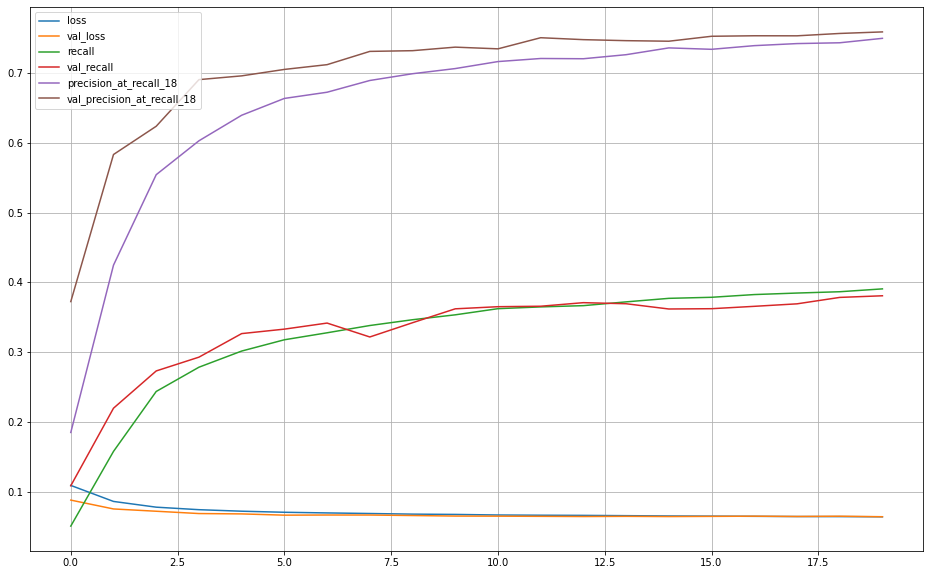

In [79]:
cols_1 = ['loss', 'val_loss', 'recall', 'val_recall', 'precision_at_recall_18', 'val_precision_at_recall_18' ]
pd.DataFrame(history.history)[cols_1].plot(figsize=(16,10))
plt.grid(True)
# plt.gca().set_ylim(0,1)
plt.show()

(0.0, 0.14221166782081127)

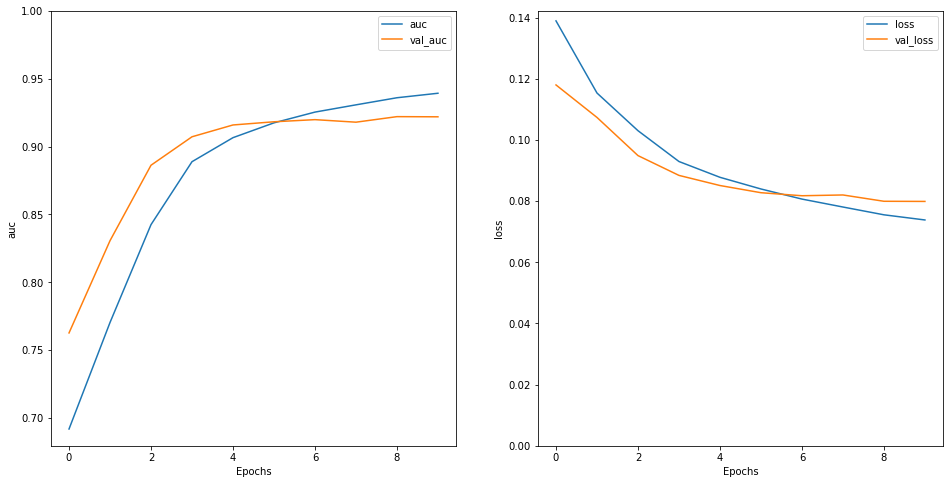

In [25]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'auc')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [47]:
history.model

In [7]:
COUNT = 100000
SPLIT_RATIO = .8
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 128

dataset =  tf.data.Dataset.from_tensor_slices((df['Body'][:COUNT], y_tags[:COUNT]))
train_dataset, test_dataset = dataset.take(dataset.cardinality().numpy()*SPLIT_RATIO), dataset.skip(dataset.cardinality().numpy()*SPLIT_RATIO)
train_data = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_data = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [8]:
VOCAB_SIZE = 5000
SEQUENCE_LENGTH = 128

vectorize_layer = TextVectorization(
#     standardize=custom_standardization,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
#     output_sequence_length=SEQUENCE_LENGTH,
    )

text_ds = train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [11]:
EMBEDDING_DIM = 48
DROPOUT = .3
LABEL_SMOOTHING =0

model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBEDDING_DIM,
#         mask_zero=True,
        name="embedding"),
#     tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(EMBEDDING_DIM)),
    tf.keras.layers.Dense(EMBEDDING_DIM,
            activation='relu',
                ),
    tf.keras.layers.Dropout(DROPOUT),
#     tf.keras.layers.Dense(EMBEDDING_DIM, activation='relu', 
#                 ),
#     tf.keras.layers.Dropout(.25),
    tf.keras.layers.Dense(51, activation='sigmoid'),
])

metrics = [
    tf.keras.metrics.PrecisionAtRecall(0.4),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.FalsePositives(name='fp'),
#     keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
#     keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

optimizer = tf.keras.optimizers.Adamax(learning_rate=0.01)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING),
    metrics=metrics,
)
# model.summary()

In [12]:
history = model.fit(
    train_data,
    epochs=10,
    validation_data=test_data,
)

Epoch 1/10
250/250 [==============================] - 39s 87ms/step - loss: 0.1891 - auc: 0.6563 - val_loss: 0.1176 - val_auc: 0.7565
Epoch 2/10
250/250 [==============================] - 21s 84ms/step - loss: 0.1193 - auc: 0.7414 - val_loss: 0.1076 - val_auc: 0.8203
Epoch 3/10
250/250 [==============================] - 21s 84ms/step - loss: 0.1092 - auc: 0.8060 - val_loss: 0.1023 - val_auc: 0.8490
Epoch 4/10
250/250 [==============================] - 21s 85ms/step - loss: 0.1017 - auc: 0.8466 - val_loss: 0.0978 - val_auc: 0.8715
Epoch 5/10
250/250 [==============================] - 20s 81ms/step - loss: 0.0961 - auc: 0.8737 - val_loss: 0.0950 - val_auc: 0.8824
Epoch 6/10
250/250 [==============================] - 20s 81ms/step - loss: 0.0916 - auc: 0.8923 - val_loss: 0.0924 - val_auc: 0.8909
Epoch 7/10
250/250 [==============================] - 21s 85ms/step - loss: 0.0870 - auc: 0.9087 - val_loss: 0.0912 - val_auc: 0.8943
Epoch 8/10
250/250 [==============================] - 21s 83ms

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x0000018E8A30C4C8>
Traceback (most recent call last):
  File "C:\Users\vince\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "C:\Users\vince\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\gen_dataset_ops.py", line 1263, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


250/250 [==============================] - 13s 53ms/step - loss: 0.0773 - auc: 0.9342 - val_loss: 0.0873 - val_auc: 0.9012


In [30]:
test_loss, test_acc = model.evaluate(test_data)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

63/63 [==============================] - 1s 23ms/step - loss: 0.0925 - auc: 0.8844
Test Loss: 0.09254556894302368
Test Accuracy: 0.884442925453186


(0.0, 0.14245018772780896)

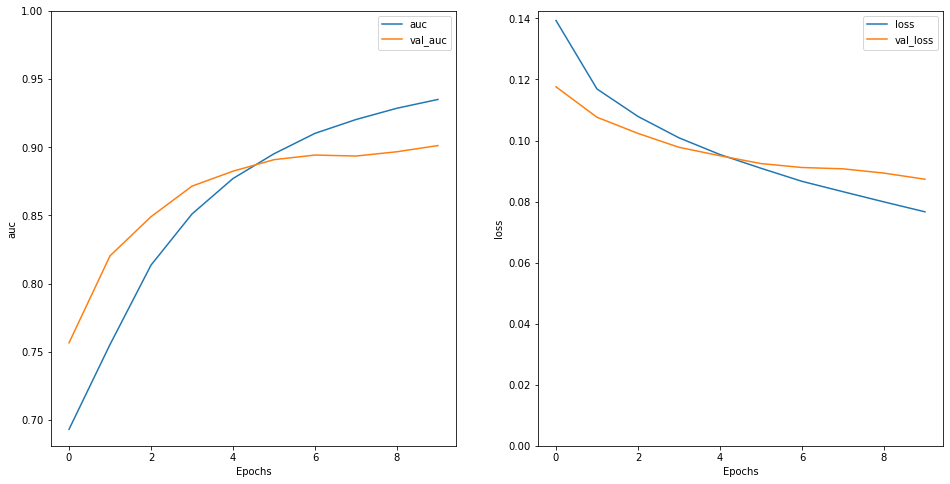

In [13]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'auc')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [7]:
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer


C:\Users\vince\AppData\Roaming\Python\Python37\site-packages\tensorflow_addons\utils\ensure_tf_install.py:43: UserWarning: You are currently using a nightly version of TensorFlow (2.6.0-dev20210413). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  UserWarning,


In [8]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 
# 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1'
# 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [9]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [10]:
text_test = ['help on python array']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101  2393  2006 18750  9140   102     0     0     0     0     0     0]
Input Mask : [1 1 1 1 1 1 0 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [52]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.2 )(net)
    net = tf.keras.layers.Dense(48, activation='relu', name='HIDDEN_1')(net)
    net = tf.keras.layers.Dropout(0.25)(net)
    net = tf.keras.layers.Dense(51, activation='sigmoid', name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [53]:

df_base.columns

Index(['Id', 'Title', 'Body', 'Tags', 'CreationDate', 'Bs4_Body', 'Code',
       'Bs4_Tags'],
      dtype='object')

In [54]:
COUNT = 50000
SPLIT_RATIO = .8
BATCH_SIZE = 48
SHUFFLE_BUFFER_SIZE = 128

# dataset =  tf.data.Dataset.from_tensor_slices((df['Body'][:COUNT], y_tags[:COUNT]))
dataset =  tf.data.Dataset.from_tensor_slices((df_base['Bs4_Body'][:COUNT], y_tags[:COUNT]))


train_dataset, test_dataset = dataset.take(dataset.cardinality().numpy()*SPLIT_RATIO), dataset.skip(dataset.cardinality().numpy()*SPLIT_RATIO)
train_data = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_data = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [55]:
classifier_model = build_classifier_model()
# bert_raw_result = classifier_model(tf.constant(text_test))
# print(tf.sigmoid(bert_raw_result))

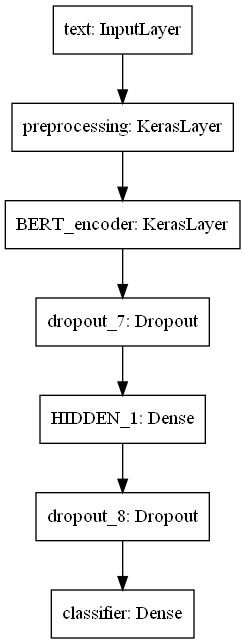

In [56]:
tf.keras.utils.plot_model(classifier_model)

In [57]:
loss = tf.keras.losses.BinaryCrossentropy(
#     from_logits=True
    )
# metrics = tf.metrics.BinaryAccuracy()
metrics = [
    tf.keras.metrics.PrecisionAtRecall(0.4),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.FalsePositives(name='fp'),
#     keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
#     keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [58]:
epochs = 7
steps_per_epoch = tf.data.experimental.cardinality(train_data).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 1e-3
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [59]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics,
#                          metrics=['AUC'],
                        )

In [60]:
history = classifier_model.fit(x=train_data,
                               validation_data=test_data,
                               epochs=epochs)

Epoch 1/7
834/834 [==============================] - 457s 544ms/step - loss: 0.3122 - precision_at_recall_5: 0.0522 - recall: 0.2150 - auc: 0.6400 - fp: 77708.9928 - fn: 24080.1066 - tp: 5523.9126 - accuracy: 0.8564 - precision: 0.0623 - val_loss: 0.0781 - val_precision_at_recall_5: 0.6145 - val_recall: 0.2798 - val_auc: 0.9222 - val_fp: 1574.0000 - val_fn: 10898.0000 - val_tp: 4234.0000 - val_accuracy: 0.9755 - val_precision: 0.7290
Epoch 2/7
834/834 [==============================] - 420s 504ms/step - loss: 0.0845 - precision_at_recall_5: 0.5267 - recall: 0.2867 - auc: 0.8996 - fp: 4560.8766 - fn: 20831.4096 - tp: 8773.5246 - accuracy: 0.9748 - precision: 0.6470 - val_loss: 0.0683 - val_precision_at_recall_5: 0.7389 - val_recall: 0.4051 - val_auc: 0.9422 - val_fp: 2210.0000 - val_fn: 9002.0000 - val_tp: 6130.0000 - val_accuracy: 0.9780 - val_precision: 0.7350
Epoch 3/7
834/834 [==============================] - 364s 436ms/step - loss: 0.0705 - precision_at_recall_5: 0.6911 - recall: 

KeyboardInterrupt: 

In [ ]:
cols_1 = ['loss', 'val_loss', 'recall', 'val_recall', 'precision_at_recall_3', 'val_precision_at_recall_3' ]
pd.DataFrame(history.history)[cols_1].plot(figsize=(16,10))
plt.grid(True)
# plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'auc')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [69]:
test_loss, test_acc = model.evaluate(test_data)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

209/209 [==============================] - 5s 23ms/step - loss: 0.0925 - auc: 0.8867
Test Loss: 0.09254700690507889
Test Accuracy: 0.8867020606994629
